In [1]:
# 1. УСТАНОВКА БИБЛИОТЕК
print("Установка библиотек...")
!pip install -q ultralytics opencv-python gradio pillow matplotlib

# 2. ИМПОРТ
import cv2
import numpy as np
import gradio as gr
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import requests
from pathlib import Path

print("Библиотеки загружены!")

Установка библиотек...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Библиотеки загружены!



ЗАГРУЗКА МОДЕЛИ YOLOv8 (предобучена на 80 классах COCO)

Определяем классы мусора в COCO...
Всего классов мусора в COCO: 23
Примеры классов: ['bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich']

СКАЧИВАНИЕ ТЕСТОВЫХ ИЗОБРАЖЕНИЙ
Скачиваем beach_pollution.jpg...
  ✓ Успешно
Скачиваем plastic_waste.jpg...
  ✓ Успешно
Скачиваем urban_trash.jpg...
  ✓ Успешно
Скачиваем river_pollution.jpg...
  ✓ Успешно
Скачиваем park_waste.jpg...
  ✓ Успешно
Скачиваем ocean_plastic.jpg...
  ✗ Ошибка: HTTPSConnectionPool(host='hakaimagazine.com', port=443): Read timed out.

✅ Скачано изображений: 5

ТЕСТИРОВАНИЕ МОДЕЛИ НА ИЗОБРАЖЕНИЯХ

📁 Обработка: beach_pollution.jpg

🔍 Детекция мусора (порог: 0.25)...
Всего обнаружено объектов: 4
Из них мусора: 4

📊 Обнаруженный мусор:
  - bottle: 46.51%
  - bottle: 40.59%
  - carrot: 30.74%
  - bottle: 29.40%


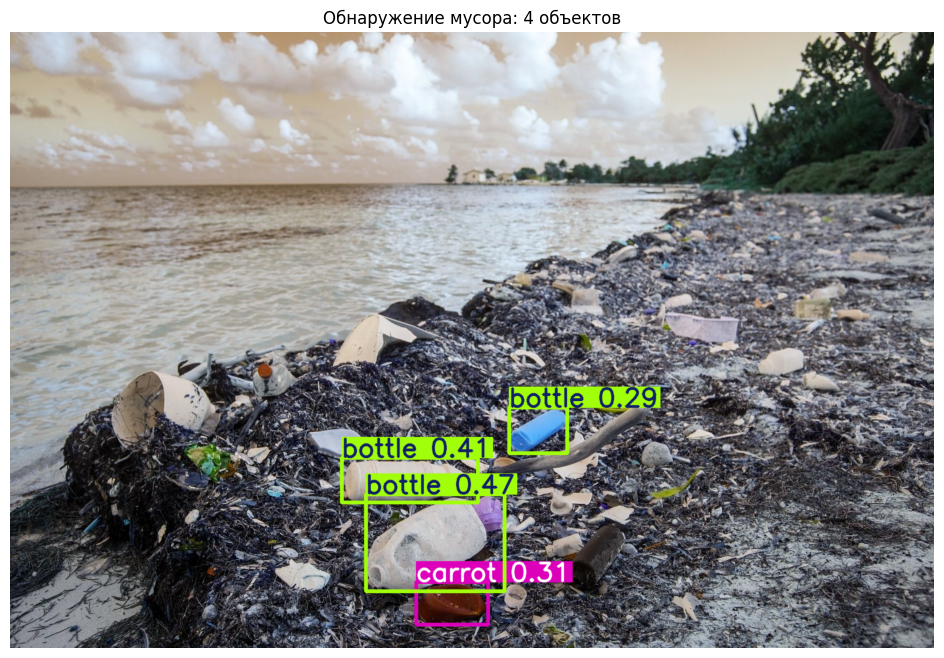


📁 Обработка: plastic_waste.jpg

🔍 Детекция мусора (порог: 0.25)...
Всего обнаружено объектов: 4
Из них мусора: 3

📊 Обнаруженный мусор:
  - bottle: 56.94%
  - bottle: 48.27%
  - bottle: 36.79%


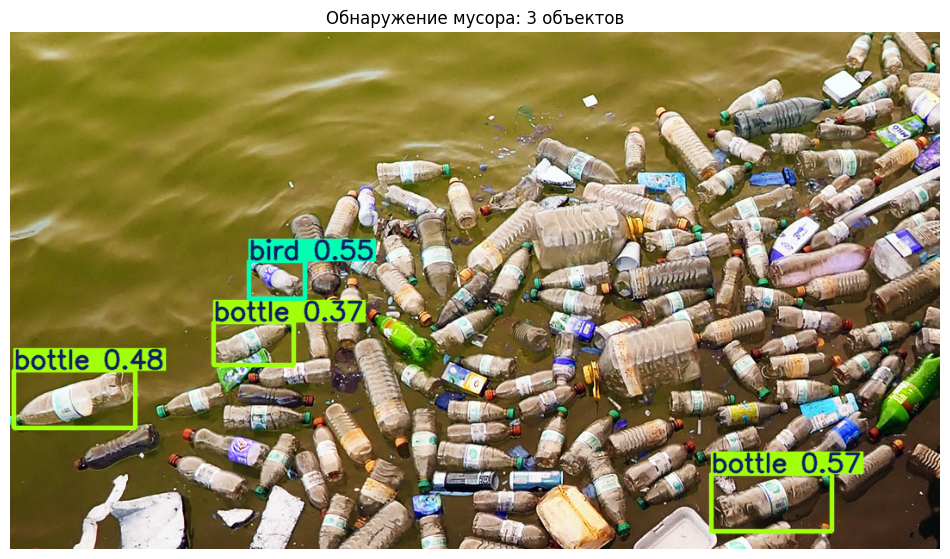


📁 Обработка: urban_trash.jpg

🔍 Детекция мусора (порог: 0.25)...
Всего обнаружено объектов: 9
Из них мусора: 0


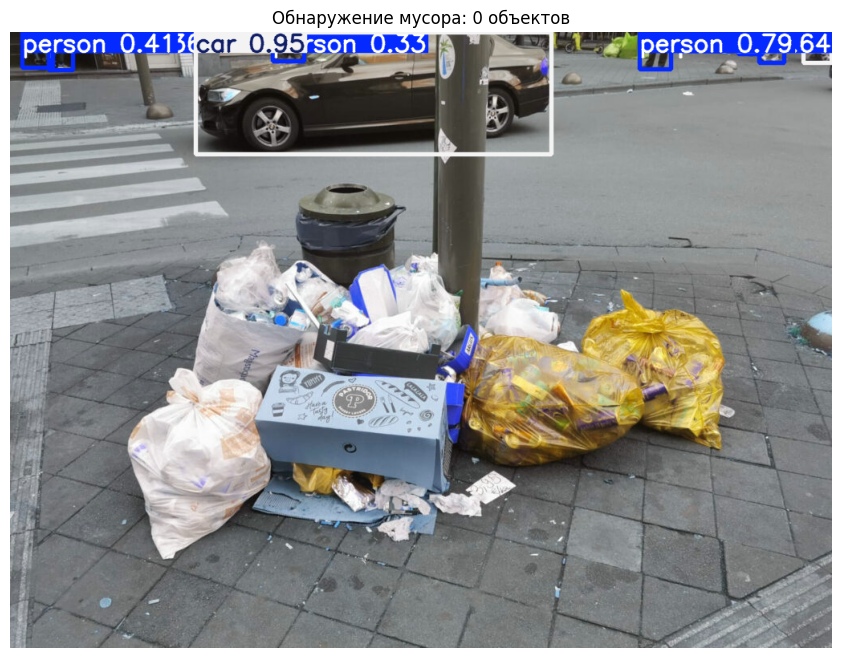


СОЗДАНИЕ ВЕБ-ИНТЕРФЕЙСА

🚀 ЗАПУСК ВЕБ-ИНТЕРФЕЙСА...
👉 Откройте ссылку ниже (может занять несколько секунд)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gradio/interface.py:171: UserWarning: The parameters have been moved from the Blocks constructor to the launch() method in Gradio 6.0: theme. Please pass these parameters to launch() instead.
  super().__init__(


* Running on local URL:  http://127.0.0.1:7871
* Running on public URL: https://96e8a2658db00feab8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



ПАКЕТНЫЙ АНАЛИЗ ИЗОБРАЖЕНИЙ


In [13]:
# 3. ЗАГРУЗКА МОДЕЛИ YOLOv8 (предобучена на COCO)
print("\n" + "="*60)
print("ЗАГРУЗКА МОДЕЛИ YOLOv8 (предобучена на 80 классах COCO)")
print("="*60)

# model = YOLO('yolov8n.pt')  # nano версия (быстрая)
# model = YOLO('yolov8s.pt')  # small (точнее)
model = YOLO('yolov8m.pt')  # medium (еще точнее)

# 4. ОПРЕДЕЛЯЕМ КЛАССЫ МУСОРА В COCO
print("\nОпределяем классы мусора в COCO...")

# Классы COCO, относящиеся к мусору/загрязнениям
WASTE_CLASSES_COCO = {
    39: 'bottle',        # Бутылка (пластик, стекло)
    40: 'wine glass',    # Бокал
    41: 'cup',           # Чашка (пластик, бумага)
    42: 'fork',          # Вилка
    43: 'knife',         # Нож
    44: 'spoon',         # Ложка
    45: 'bowl',          # Миска
    46: 'banana',        # Банан (органические отходы)
    47: 'apple',         # Яблоко (органические отходы)
    48: 'sandwich',      # Сэндвич (органические отходы)
    49: 'orange',        # Апельсин (органические отходы)
    50: 'broccoli',      # Брокколи (органические отходы)
    51: 'carrot',        # Морковь (органические отходы)
    52: 'hot dog',       # Хот-дог (органические отходы)
    53: 'pizza',         # Пицца (органические отходы)
    54: 'donut',         # Пончик (органические отходы)
    55: 'cake',          # Торт (органические отходы)
    67: 'cell phone',    # Телефон (электронные отходы)
    73: 'book',          # Книга (бумага)
    76: 'scissors',      # Ножницы (металл/пластик)
    77: 'teddy bear',    # Плюшевый мишка (текстиль)
    78: 'hair drier',    # Фен (электронные отходы)
    79: 'toothbrush',    # Зубная щетка (пластик)
}

print(f"Всего классов мусора в COCO: {len(WASTE_CLASSES_COCO)}")
print("Примеры классов:", list(WASTE_CLASSES_COCO.values())[:10])

# 5. ФУНКЦИЯ ДЛЯ ДЕТЕКЦИИ МУСОРА
def detect_waste_coco(image_path_or_array, confidence=0.25, show_result=True):
    """
    Обнаружение мусора с помощью предобученной YOLOv8 на COCO
    """
    print(f"\n🔍 Детекция мусора (порог: {confidence})...")
    
    # Запускаем детекцию
    results = model(image_path_or_array, conf=confidence, verbose=False)
    
    # Фильтруем только классы мусора
    waste_detections = []
    all_detections = []
    
    if results and results[0].boxes is not None:
        result = results[0]
        
        for box in result.boxes:
            class_id = int(box.cls[0])
            class_name = result.names[class_id]
            confidence_score = float(box.conf[0])
            bbox = box.xyxy[0].tolist()  # [x1, y1, x2, y2]
            
            detection = {
                'class_id': class_id,
                'class_name': class_name,
                'confidence': confidence_score,
                'bbox': bbox
            }
            
            all_detections.append(detection)
            
            # Проверяем, является ли объект мусором
            if class_id in WASTE_CLASSES_COCO:
                waste_detections.append(detection)
    
    # Выводим результаты
    print(f"Всего обнаружено объектов: {len(all_detections)}")
    print(f"Из них мусора: {len(waste_detections)}")
    
    if waste_detections:
        print("\n📊 Обнаруженный мусор:")
        for det in waste_detections:
            print(f"  - {det['class_name']}: {det['confidence']:.2%}")
    
    # Визуализируем результат
    if show_result and results:
        result_img = results[0].plot()
        plt.figure(figsize=(12, 8))
        plt.imshow(result_img[..., ::-1])  # Конвертируем BGR -> RGB
        plt.axis('off')
        plt.title(f'Обнаружение мусора: {len(waste_detections)} объектов')
        plt.show()
    
    return results, waste_detections, all_detections

# 6. СКАЧИВАЕМ ТЕСТОВЫЕ ИЗОБРАЖЕНИЯ
print("\n" + "="*60)
print("СКАЧИВАНИЕ ТЕСТОВЫХ ИЗОБРАЖЕНИЙ")
print("="*60)

def download_test_images():
    """Скачиваем тестовые изображения с мусором"""
    
    test_images = {
    #     "beach_pollution.jpg": "https://images.unsplash.com/photo-1578489758854-f134a358f08b",
    #     "plastic_waste.jpg": "https://images.unsplash.com/photo-1542601906990-b4d3fb778b09",
    #     "urban_trash.jpg": "https://images.unsplash.com/photo-1585747860715-2ba37e788b70",
    #     "river_pollution.jpg": "https://images.unsplash.com/photo-1558642452-9d2a7deb7f62",
    #     "park_waste.jpg": "https://images.unsplash.com/photo-1513475382585-d06e58bcb0e0",
    #     "ocean_plastic.jpg": "https://images.unsplash.com/photo-1562077982-8922-7efc4ef10c8e"
    # }
        "beach_pollution.jpg": "https://cleanwater.org/sites/default/files/images/actions/RI_plastic%20on%20beach_canva.jpg",
        "plastic_waste.jpg": "https://www.advancedsciencenews.com/wp-content/uploads/2019/01/plastic-3151246_1920.jpg",
        "urban_trash.jpg": "https://api.brusselstimes.com/wp-content/uploads/2022/10/328d6ac6-belgaimage-43248569-1024x768.jpeg",
        "river_pollution.jpg": "https://images.squarespace-cdn.com/content/v1/65272e44bd4f9022f58884d2/b58dbcb1-6818-4a7b-b0f0-d13c40d0c09b/Most-Polluted-Rivers-in-the-World.jpg",
        "park_waste.jpg": "https://s.hdnux.com/photos/34/77/76/7602051/6/rawImage.jpg",
        "ocean_plastic.jpg": "https://hakaimagazine.com/wp-content/uploads/header-plastic-cleanup-conundrum.jpg"
    }
    
    downloaded = []
    
    for filename, url in test_images.items():
        try:
            print(f"Скачиваем {filename}...")
            response = requests.get(f"{url}?ixlib=rb-1.2.1&auto=format&fit=crop&w=800&q=80", timeout=10)
            
            # Сохраняем изображение
            with open(filename, 'wb') as f:
                f.write(response.content)
            
            downloaded.append(filename)
            print(f"  ✓ Успешно")
            
        except Exception as e:
            print(f"  ✗ Ошибка: {e}")
    
    return downloaded

# Скачиваем изображения
test_files = download_test_images()

if test_files:
    print(f"\n✅ Скачано изображений: {len(test_files)}")
else:
    print("\n⚠️ Не удалось скачать изображения, создаем тестовые...")
    # Создаем простое тестовое изображение
    img = np.zeros((400, 600, 3), dtype=np.uint8)
    cv2.putText(img, "Тестовое изображение с мусором", (50, 200), 
               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.imwrite("test_waste.jpg", img)
    test_files = ["test_waste.jpg"]

# 7. ТЕСТИРУЕМ МОДЕЛЬ
print("\n" + "="*60)
print("ТЕСТИРОВАНИЕ МОДЕЛИ НА ИЗОБРАЖЕНИЯХ")
print("="*60)

for img_file in test_files[:3]:  # Тестируем на первых 3 изображениях
    print(f"\n📁 Обработка: {img_file}")
    
    if os.path.exists(img_file):
        # Загружаем изображение
        img = cv2.imread(img_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Детекция
        results, waste_detections, all_detections = detect_waste_coco(
            img_rgb, 
            confidence=0.25,
            show_result=True
        )
    else:
        print(f"Файл {img_file} не найден")

# 8. СОЗДАЕМ GRADIO ВЕБ-ИНТЕРФЕЙС
print("\n" + "="*60)
print("СОЗДАНИЕ ВЕБ-ИНТЕРФЕЙСА")
print("="*60)

def analyze_waste(image, confidence=0.25):
    """
    Функция для Gradio интерфейса
    """
    # Конвертируем PIL в numpy array
    if isinstance(image, Image.Image):
        img_np = np.array(image)
    else:
        img_np = image
    
    # Конвертируем RGB в BGR для OpenCV
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = img_np
    
    # Детекция
    results = model(img_bgr, conf=confidence, verbose=False)
    
    if results and results[0].boxes is not None:
        result = results[0]
        
        # Создаем изображение с bounding boxes
        annotated_img = result.plot()
        
        # Конвертируем BGR -> RGB для отображения
        annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        # Считаем статистику
        waste_stats = {}
        total_waste = 0
        
        for box in result.boxes:
            class_id = int(box.cls[0])
            class_name = result.names[class_id]
            
            if class_id in WASTE_CLASSES_COCO:
                if class_name not in waste_stats:
                    waste_stats[class_name] = 0
                waste_stats[class_name] += 1
                total_waste += 1
        
        # Создаем отчет
        if total_waste > 0:
            report = f"✅ ОБНАРУЖЕНО МУСОРА: {total_waste} объектов\n\n"
            for waste_type, count in waste_stats.items():
                report += f"• {waste_type}: {count} шт.\n"
            
            # Добавляем рекомендации
            report += "\n🌍 РЕКОМЕНДАЦИИ:\n"
            
            if 'bottle' in waste_stats:
                report += "- Соберите пластиковые бутылки для переработки\n"
            if any(x in waste_stats for x in ['cup', 'fork', 'knife', 'spoon']):
                report += "- Одноразовая посуда подлежит переработке\n"
            if any(x in waste_stats for x in ['book', 'newspaper']):
                report += "- Бумажные отходы можно сдать в макулатуру\n"
            if 'banana' in waste_stats or 'apple' in waste_stats:
                report += "- Органические отходы можно компостировать\n"
        else:
            report = "✅ ЧИСТО! Мусор не обнаружен."
            annotated_img_rgb = img_np  # Показываем оригинальное изображение
    
    else:
        annotated_img_rgb = img_np
        report = "❌ Объекты не обнаружены."
    
    return annotated_img_rgb, report

# Создаем примеры для интерфейса
example_images = []
for img_file in test_files[:3]:
    if os.path.exists(img_file):
        example_images.append([img_file, 0.25])

# Создаем интерфейс
interface = gr.Interface(
    fn=analyze_waste,
    inputs=[
        gr.Image(type="pil", label="📤 Загрузите изображение"),
        gr.Slider(0, 1, 0.25, label="🎚️ Порог уверенности", step=0.05)
    ],
    outputs=[
        gr.Image(type="numpy", label="📊 Результат детекции"),
        gr.Textbox(label="📝 Отчет и рекомендации")
    ],
    title="🌍 ЭКО-ДЕТЕКТОР: Обнаружение мусора и загрязнений",
    description="""
    <div style='text-align: center;'>
    <h3>Автоматическое обнаружение мусора и загрязнений окружающей среды</h3>
    <p>Загрузите фотографию пляжа, парка, улицы или любого другого места для анализа</p>
    <p><strong>Модель обнаруживает:</strong> пластик, стекло, бумагу, металл, органические отходы</p>
    </div>
    """,
    examples=example_images,
    theme=gr.themes.Soft(),
    flagging_mode="never"
)

print("\n🚀 ЗАПУСК ВЕБ-ИНТЕРФЕЙСА...")
print("👉 Откройте ссылку ниже (может занять несколько секунд)")

# Запускаем интерфейс
try:
    interface.launch(share=True, debug=False)
except Exception as e:
    print(f"Ошибка при запуске интерфейса: {e}")
    print("\nПробуем запустить без sharing...")
    interface.launch(debug=False)

# 9. ФУНКЦИЯ ДЛЯ АНАЛИЗА ПАПКИ С ИЗОБРАЖЕНИЯМИ
print("\n" + "="*60)
print("ПАКЕТНЫЙ АНАЛИЗ ИЗОБРАЖЕНИЙ")
print("="*60)

def batch_analyze_folder(folder_path, confidence=0.25):
    """
    Анализ всех изображений в папке
    """
    if not os.path.exists(folder_path):
        print(f"Папка {folder_path} не найдена!")
        return
    
    # Поддерживаемые форматы
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
    
    # Находим все изображения
    image_files = []
    for file in os.listdir(folder_path):
        ext = os.path.splitext(file)[1].lower()
        if ext in image_extensions:
            image_files.append(os.path.join(folder_path, file))
    
    if not image_files:
        print("В папке нет изображений!")
        return
    
    print(f"Найдено изображений: {len(image_files)}")
    print("Начинаем анализ...")
    
    results_summary = {}
    
    for i, img_path in enumerate(image_files, 1):
        print(f"\n[{i}/{len(image_files)}] Анализ: {os.path.basename(img_path)}")
        
        # Загружаем изображение
        img = cv2.imread(img_path)
        if img is None:
            print(f"  ✗ Не удалось загрузить изображение")
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Детекция
        results, waste_detections, _ = detect_waste_coco(
            img_rgb, 
            confidence=confidence,
            show_result=False
        )
        
        # Сохраняем результат
        if waste_detections:
            # Создаем директорию для результатов
            output_dir = os.path.join(folder_path, "waste_detection_results")
            os.makedirs(output_dir, exist_ok=True)
            
            # Сохраняем аннотированное изображение
            if results and results[0]:
                result_img = results[0].plot()
                output_path = os.path.join(output_dir, f"detected_{os.path.basename(img_path)}")
                cv2.imwrite(output_path, result_img)
                print(f"  ✓ Результат сохранен: {output_path}")
            
            # Записываем статистику
            for det in waste_detections:
                class_name = det['class_name']
                results_summary[class_name] = results_summary.get(class_name, 0) + 1
        else:
            print(f"  ✓ Мусор не обнаружен")
    
    # Выводим общую статистику
    if results_summary:
        print("\n" + "="*60)
        print("📊 ОБЩАЯ СТАТИСТИКА ПО ПАПКЕ:")
        print("="*60)
        
        total_waste = sum(results_summary.values())
        print(f"Всего обнаружено объектов мусора: {total_waste}")
        
        print("\nРаспределение по типам:")
        for waste_type, count in sorted(results_summary.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / total_waste) * 100
            print(f"  • {waste_type}: {count} шт. ({percentage:.1f}%)")
    else:
        print("\n✅ Во всех изображениях мусор не обнаружен!")

# # Пример использования (раскомментируйте при необходимости):
# batch_analyze_folder("/content/test_images", confidence=0.25)

# # 10. СОХРАНЕНИЕ МОДЕЛИ И РЕЗУЛЬТАТОВ
# print("\n" + "="*60)
# print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
# print("="*60)

# # Создаем папку для сохранения
# output_dir = Path("/content/waste_detection_output")
# output_dir.mkdir(exist_ok=True)

# # Сохраняем информацию о модели
# model_info = f"""
# # ИНФОРМАЦИЯ О МОДЕЛИ ОБНАРУЖЕНИЯ МУСОРА

# Модель: YOLOv8n (предобучена на COCO)
# Дата создания: {os.path.basename(output_dir)}
# Классы мусора: {len(WASTE_CLASSES_COCO)}

# ## Обнаруживаемые типы мусора:
# {chr(10).join([f'- {cls}' for cls in WASTE_CLASSES_COCO.values()])}"""
